In [1]:
# imports
import timeit
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from pickle import dump, load

from sklearn.metrics import r2_score, mean_squared_error


from sklearn.linear_model import LinearRegression

import warnings

# Filter out any warning
warnings.filterwarnings("ignore")

/Users/eric/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Read in Data

In [2]:
df = pd.read_csv('Data/cleaned_vehicles_df.csv', index_col = 0)
df

,posting_year,year_manufactured,manufacturer,model,state,region,price,fuel,miles,cylinders,title_status,transmission,drive,type,paint_color
0,2021,2014,gmc,sierra 1500 crew cab slt,al,auburn,33590,gas,57923.0,8 cylinders,clean,other,NaN,pickup,white
1,2021,2010,chevrolet,silverado 1500,al,auburn,22590,gas,71229.0,8 cylinders,clean,other,NaN,pickup,blue
2,2021,2020,chevrolet,silverado 1500 crew,al,auburn,39590,gas,19160.0,8 cylinders,clean,other,NaN,pickup,red
3,2021,2017,toyota,tundra double cab sr,al,auburn,30990,gas,41124.0,8 cylinders,clean,other,NaN,pickup,red
4,2021,2013,ford,f-150 xlt,al,auburn,15000,gas,128000.0,6 cylinders,clean,automatic,rwd,truck,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399878,2021,2019,nissan,maxima s sedan 4d,wy,wyoming,23590,gas,32226.0,6 cylinders,clean,other,fwd,sedan,NaN
399879,2021,2020,volvo,s60 t5 momentum sedan 4d,wy,wyoming,30590,gas,12029.0,NaN,clean,other,fwd,sedan,red
399880,2021,2020,cadillac,xt4 sport suv 4d,wy,wyoming,34990,diesel,4174.0,NaN,clean,other,NaN,hatchback,white
399881,2021,2018,lexus,es 350 sedan 4d,wy,wyoming,28990,gas,30112.0,6 cylinders,clean,other,fwd,sedan,silver


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399883 entries, 0 to 399882
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   posting_year       399883 non-null  int64  
 1   year_manufactured  399883 non-null  int64  
 2   manufacturer       399883 non-null  object 
 3   model              399883 non-null  object 
 4   state              399883 non-null  object 
 5   region             399883 non-null  object 
 6   price              399883 non-null  int64  
 7   fuel               397874 non-null  object 
 8   miles              399883 non-null  float64
 9   cylinders          235585 non-null  object 
 10  title_status       392710 non-null  object 
 11  transmission       398275 non-null  object 
 12  drive              280317 non-null  object 
 13  type               316647 non-null  object 
 14  paint_color        280565 non-null  object 
dtypes: float64(1), int64(3), object(11)
memory usage: 48.8+ 

### Filtering outliers

In [4]:
print(df['price'].min())
print(df['price'].max())

0
3736928711


In [5]:
# Function to filter outliers using IQR
def filter_iqr_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


In [6]:
df = filter_iqr_outliers(df, ['price'])

#### Filter out 0 price vehicles

In [7]:
df = df[df['price']>0]

## Build Baseline Models to Predict Price

### Train-Test Split

#### Check number of unique values for categorical fields 

In [8]:
# Initialize an empty dictionary to store results
unique_counts = {}

# Loop through each column in the DataFrame
for col in df.columns:
    if df[col].dtype == 'object':  # Check if column is categorical (object type)
        unique_counts[col] = df[col].nunique()  # Count number of unique values

# Print the number of unique values for each categorical column
for col, count in unique_counts.items():
    print(f"Column '{col}' has {count} unique values.")

Column 'manufacturer' has 41 unique values.
Column 'model' has 21840 unique values.
Column 'state' has 51 unique values.
Column 'region' has 404 unique values.
Column 'fuel' has 5 unique values.
Column 'cylinders' has 8 unique values.
Column 'title_status' has 6 unique values.
Column 'transmission' has 3 unique values.
Column 'drive' has 3 unique values.
Column 'type' has 13 unique values.
Column 'paint_color' has 12 unique values.


In [9]:
# target variable is price; drop posting_year as not relevant
df = df.drop(['posting_year', 'region', 'model'], axis=1)
X = df.drop(['price'], axis = 1)

y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.90)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(327672, 11)
(36409, 11)
(327672,)
(36409,)


## Data Cleaning

Will still need to impute missing values in the following columns:

In [11]:
# Fill missing values with mode for each column
X_train = X_train.apply(lambda x: x.fillna(x.mode()[0]))
X_train.head()

,year_manufactured,manufacturer,state,fuel,miles,cylinders,title_status,transmission,drive,type,paint_color
25784,2012,subaru,ca,gas,52355.0,4 cylinders,clean,automatic,4wd,sedan,white
20236,2015,toyota,ca,gas,66732.0,6 cylinders,clean,other,fwd,hatchback,white
276430,2002,toyota,oh,gas,155500.0,6 cylinders,clean,automatic,fwd,convertible,red
344512,2009,gmc,tx,gas,186168.0,8 cylinders,clean,automatic,4wd,pickup,grey
160207,2017,kia,ky,hybrid,30257.0,4 cylinders,clean,automatic,fwd,sedan,white


In [12]:
# helper function to impute missing values in dataframe columns
def impute_cols(dataset):
    '''
    Helper function takes in the dataset and identifies the columns with missing values and imputes the 
    mode value in each column.
    '''
    
    # filter for cols with missing values as a series
    cols = dataset.isnull().sum() >0

    # extract the cols from the series
    missing_cols = cols[cols].index.tolist()
    
    # fill missing cat cols with mode
    mode_values = dataset[missing_cols].mode()
#     display("Mode Values in each column:", mode_values)
    
    # Fill missing values with mode for each column
    imputed_dataset = dataset.apply(lambda x: x.fillna(x.mode()[0]))
    
    return imputed_dataset

In [13]:
X_train = impute_cols(X_train)

In [14]:
X_test = impute_cols(X_test)

#### Calculate Age of Vehicle

In [15]:
# calculate age
X_train['age'] = 2024 - X_train['year_manufactured']
X_test['age'] = 2024 - X_test['year_manufactured']

# drop year_manufactured
X_train = X_train.drop(columns = 'year_manufactured')
X_test = X_test.drop(columns = 'year_manufactured')

In [16]:
X_train.head()

,manufacturer,state,fuel,miles,cylinders,title_status,transmission,drive,type,paint_color,age
25784,subaru,ca,gas,52355.0,4 cylinders,clean,automatic,4wd,sedan,white,12
20236,toyota,ca,gas,66732.0,6 cylinders,clean,other,fwd,hatchback,white,9
276430,toyota,oh,gas,155500.0,6 cylinders,clean,automatic,fwd,convertible,red,22
344512,gmc,tx,gas,186168.0,8 cylinders,clean,automatic,4wd,pickup,grey,15
160207,kia,ky,hybrid,30257.0,4 cylinders,clean,automatic,fwd,sedan,white,7


### Preprocessing
#### Build `ColumnTransformer`

In [17]:
# define categorical columns to be OHE
cat_cols = X_train.select_dtypes(['object']).columns

# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns

In [18]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) # apply a standard scaler

# define a nominal transformation pipeline that OHE the cats, and MaxAbsScales the set
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories="auto", # ohe the cat variables
                                                         sparse_output = False))]) 

In [19]:
# transform the selected columns with nominal, and numeric pipelines
pp_ct = ColumnTransformer(transformers = 
                    [("nominalpipe", nominal_pipeline, cat_cols), 
                     ("numpipe", numeric_pipeline, num_cols)])

### Rearrange X_train and X_test column names for simplicity later on

In [20]:
# new order of cols
order = list(cat_cols) + list(num_cols)

# set new order on training and test
X_train = X_train[order]
X_test = X_test[order]

In [21]:
X_train.head()

,manufacturer,state,fuel,cylinders,title_status,transmission,drive,type,paint_color,miles,age
25784,subaru,ca,gas,4 cylinders,clean,automatic,4wd,sedan,white,52355.0,12
20236,toyota,ca,gas,6 cylinders,clean,other,fwd,hatchback,white,66732.0,9
276430,toyota,oh,gas,6 cylinders,clean,automatic,fwd,convertible,red,155500.0,22
344512,gmc,tx,gas,8 cylinders,clean,automatic,4wd,pickup,grey,186168.0,15
160207,kia,ky,hybrid,4 cylinders,clean,automatic,fwd,sedan,white,30257.0,7


#### Save transformer

In [22]:
# save the transformer
dump(pp_ct, open('pkl/pp_ct.pkl', 'wb'))

In [23]:
# load the transformer
pp_ct = load(open('pkl/pp_ct.pkl', 'rb'))

### Transform the training and test sets

In [24]:
pp_X_train = pd.DataFrame(pp_ct.fit_transform(X_train))

In [25]:
pp_X_train

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.249945,-0.073208
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.170850,-0.418874
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.317510,1.079010
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486231,0.272457
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.371518,-0.649317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.199634,-0.188430
327668,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.365929,-0.994983
327669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.130557,-0.303652
327670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088960,0.157235


In [26]:
pp_X_test = pd.DataFrame(pp_ct.transform(X_test))

In [27]:
pp_X_test

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.281904,0.042014
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.053614,1.539897
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.864912,0.733345
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.453018,-0.649317
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.425587,-0.994983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36404,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347768,0.618123
36405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.012175,0.042014
36406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.012175,-0.073208
36407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.537978,0.733345


### Getting column feature names after preprocessing

In [28]:
# For categorical features, get the new feature names after one-hot encoding
categorical_feature_names = pp_ct.named_transformers_['nominalpipe']['onehotenc'].get_feature_names_out(cat_cols)

# Combine feature names
preprocessed_feature_names = list(categorical_feature_names) + list(num_cols) 

print(preprocessed_feature_names)

['manufacturer_acura', 'manufacturer_alfa-romeo', 'manufacturer_aston-martin', 'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chevrolet', 'manufacturer_chrysler', 'manufacturer_datsun', 'manufacturer_dodge', 'manufacturer_ferrari', 'manufacturer_fiat', 'manufacturer_ford', 'manufacturer_gmc', 'manufacturer_harley-davidson', 'manufacturer_honda', 'manufacturer_hyundai', 'manufacturer_infiniti', 'manufacturer_jaguar', 'manufacturer_jeep', 'manufacturer_kia', 'manufacturer_land rover', 'manufacturer_lexus', 'manufacturer_lincoln', 'manufacturer_mazda', 'manufacturer_mercedes-benz', 'manufacturer_mercury', 'manufacturer_mini', 'manufacturer_mitsubishi', 'manufacturer_nissan', 'manufacturer_pontiac', 'manufacturer_porsche', 'manufacturer_ram', 'manufacturer_rover', 'manufacturer_saturn', 'manufacturer_subaru', 'manufacturer_tesla', 'manufacturer_toyota', 'manufacturer_volkswagen', 'manufacturer_volvo', 'state_ak', 'state_al', 'state_ar'

In [29]:
pp_X_train.columns = preprocessed_feature_names
pp_X_test.columns = preprocessed_feature_names
pp_X_test

,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,...,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,miles,age
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.281904,0.042014
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.053614,1.539897
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.864912,0.733345
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.453018,-0.649317
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.425587,-0.994983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36404,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347768,0.618123
36405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.012175,0.042014
36406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.012175,-0.073208
36407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.537978,0.733345


In [30]:
# log transform the target variable
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

#### Metrics

In [31]:
# create function that gives performance metrics
def metrics(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(np.exp(y_true), np.exp(y_predict), squared = False) # False gives RMSE

    # Return the score
    return [r2, rmse]

#### Cross Validation

In [32]:
# define a simple function that returns cross validation score for a 5 fold
def get_cv_score(model, X, y):
    
    # instatiate the model
    instantiated_model = model
    # get model name
    model_name = type(instantiated_model).__name__
    
    # R2 score CV
    cv_r2_score = np.mean(cross_val_score(instantiated_model, 
                                       X, y, 
                                       scoring = 'r2', 
                                       cv = 3))    # 3 folds
    # RMSE score CV
    cv_rmse_score = np.mean(cross_val_score(instantiated_model,
                                           X,
                                           np.exp(y),
                                           scoring = 'neg_root_mean_squared_error',
                                           cv = 3))  # 3 folds
    cross_val_r2 = round(cv_r2_score, 4)
    cross_val_rmse = -round(cv_rmse_score)
    
    print(model_name, f"Cross Validation R2: {cross_val_r2}")
    print(model_name, f"Cross Validation RMSE: {cross_val_rmse}")

### Modeling
#### Baseline Model

In [33]:
def model_results(model, X_train, y_train, X_test, y_test, early_stopping_rounds=None):
    '''
    Helper function that takes input of model, and train-test split sets 
    and returns the model R2, RMSE scores
    '''
    
    # preprocess the training and test sets
    pp_X_train = pd.DataFrame(pp_ct.fit_transform(X_train))
    pp_X_test = pd.DataFrame(pp_ct.transform(X_test))
    # log scale the y_train and y_test
    log_y_train = np.log(y_train)
    log_y_test = np.log(y_test)
    
    # instatiate the model
    instantiated_model = model
    # get model name
    model_name = type(instantiated_model).__name__
    
    # Start the timer
    start_time = timeit.default_timer()
    print("BEGIN TRAINING")
    
    # Fit the model with early stopping
    if early_stopping_rounds:
        instantiated_model.fit(pp_X_train, log_y_train,
                               early_stopping_rounds=early_stopping_rounds,
                               eval_set=[(pp_X_test, log_y_test)],
                               verbose=False)
    else:
        instantiated_model.fit(pp_X_train, log_y_train)
    
#     # fit the model
#     instantiated_model.fit(pp_X_train, log_y_train)
    
    # Stop the timer
    end_time = timeit.default_timer()
    print("Training COMPLETE; Calculating predictions...")
    
    # Make predictions on the training and test data
    y_pred_train = instantiated_model.predict(pp_X_train)
    y_pred_test = instantiated_model.predict(pp_X_test)

    # Calculate performance using the metrics() function 
    train_scores = metrics(log_y_train, y_pred_train)
    test_scores = metrics(log_y_test, y_pred_test)
    # R2
    train_r2 = round(train_scores[0],4)
    test_r2 = round(test_scores[0],4)
    #RMSE
    train_rmse = round(train_scores[1])
    test_rmse = round(test_scores[1])
    
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    
    # Print elapsed time
    print(f"Elapsed time: {elapsed_time:.3f} seconds")
    print("")
    # Training
    print(model_name, f"Training R2: {train_r2}") 
    print(model_name, f"Test R2: {test_r2}") 
    print('-----' * 11)
    # Testing
    print(model_name, f"Training RMSE: {train_rmse}") 
    print(model_name, f"Model Test RMSE: {test_rmse}")
    print('-----' * 11)
    # Validation
    get_cv_score(instantiated_model, pp_X_train, log_y_train)
    print('----' * 5, 'END OF TRAINING', '----' * 5)

### Linear Regression

In [34]:
model_results(LinearRegression(), X_train, y_train, X_test, y_test)

BEGIN TRAINING
Training COMPLETE; Calculating predictions...
Elapsed time: 11.074 seconds

LinearRegression Training R2: 0.2496
LinearRegression Test R2: 0.2595
-------------------------------------------------------
LinearRegression Training RMSE: 9945
LinearRegression Model Test RMSE: 9984
-------------------------------------------------------
LinearRegression Cross Validation R2: 0.2485
LinearRegression Cross Validation RMSE: 9223
-------------------- END OF TRAINING --------------------


### XGBoost

In [35]:
import xgboost as xgb
from xgboost import XGBRegressor

In [36]:
model_results(XGBRegressor(), X_train, y_train, X_test, y_test)

BEGIN TRAINING
Training COMPLETE; Calculating predictions...
Elapsed time: 3.811 seconds

XGBRegressor Training R2: 0.5772
XGBRegressor Test R2: 0.5584
-------------------------------------------------------
XGBRegressor Training RMSE: 7062
XGBRegressor Model Test RMSE: 7218
-------------------------------------------------------
XGBRegressor Cross Validation R2: 0.537
XGBRegressor Cross Validation RMSE: 6028
-------------------- END OF TRAINING --------------------


### Optuna Hyperparameter Tuning

In [37]:
import optuna

In [38]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    model = XGBRegressor(**params) # need to specify model

    # Train XGBoost model
    model_results(model, X_train, y_train, X_test, y_test, early_stopping_rounds=100)

    # Get validation RMSE
    rmse = model.best_score

    return rmse

**NOTE:** Only run code below if new best params are needed. Otherwise, best params has been run already and saved in a previous session. 

In [39]:
# # Run Optuna optimization
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)

# # Print best parameters and best score
# xgb_best_params = study.best_params
# xgb_best_score = study.best_value

# print("Best parameters:", xgb_best_params)
# print("Best RMSE:", xgb_best_score)

In [40]:
# # Save best params to disk using pickle
# with open('pkl/xgb_best_params.pkl', 'wb') as f:
#     pickle.dump(xgb_best_params, f)

# print("Best parameters saved to pkl/xgb_best_params.pkl:")
# print(xgb_best_params)

#### Load saved best params below:

In [41]:
# load params
with open('pkl/xgb_best_params.pkl', 'rb') as f:
    xgb_best_params = pickle.load(f)

### Saving XGBoost Model

In [42]:
xgb_best_params

{'lambda': 0.953570580569836,
 'alpha': 0.4364631772977047,
 'max_depth': 7,
 'eta': 0.11849762255649525,
 'gamma': 1.3287548017355498e-08,
 'colsample_bytree': 0.6533740129778802,
 'subsample': 0.9562044514556802,
 'min_child_weight': 1}

In [43]:
# unpack best params and fit on the training set
XGBRegressor_model = XGBRegressor(**xgb_best_params).fit(pp_X_train, log_y_train)

In [44]:
XGBRegressor_model

XGBRegressor(alpha=0.4364631772977047, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6533740129778802, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.11849762255649525, eval_metric=None, feature_types=None,
             gamma=1.3287548017355498e-08, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=0.953570580569836, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, ...)

In [45]:
# # Save the model
# XGBRegressor_model.save_model('Models/XGBRegressor_model.bin')

### Feature Importances

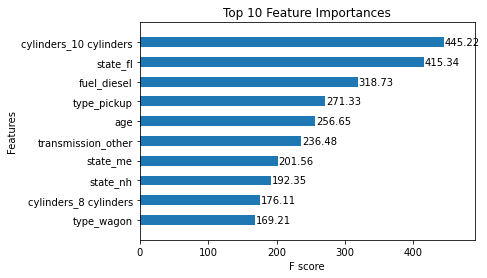

In [46]:
xgb.plot_importance(XGBRegressor_model,
                    importance_type='gain', 
                    max_num_features=10, 
                    height = 0.5,
                    grid = False,
                    values_format = "{v:.2f}",
                    title='Top 10 Feature Importances')
plt.show()

### SHAP Importances

100%|===================| 36357/36409 [02:18<00:00]        

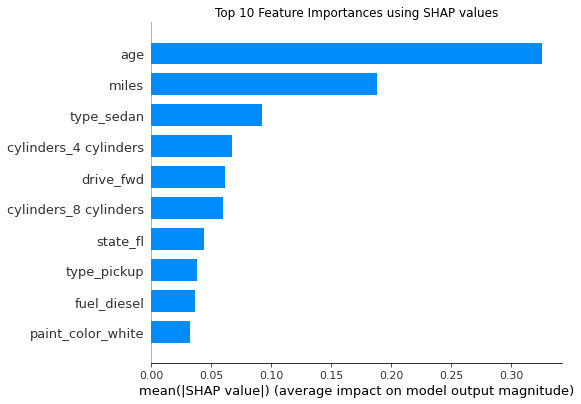

In [50]:
# Explain the model's predictions using SHAP values
explainer = shap.Explainer(XGBRegressor_model, pp_X_test)
shap_values = explainer(pp_X_test)

# Plot SHAP feature importances
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, pp_X_test, 
                  plot_type="bar", 
                  max_display=10, 
                  show=False)

plt.title('Top 10 Feature Importances using SHAP values')
plt.show()